In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch

%load_ext autoreload
%autoreload 2

In [2]:
from survshares.datasets import Rossi, Metabric, GBSG2
from sklearn.model_selection import train_test_split
# Prepare dataset
dataset = Metabric()
X, T, E = dataset.load(normalise=False)
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    X, T, E, test_size=0.2, random_state=42
)

In [3]:
from survshares.metrics import negative_pll 
from gplearn.gplearn.fitness import make_fitness

def fitness_npll_shrink(y_true, y_pred, sample_weight):
    """
    Partial log-likelihood with shrink penalty for gplearn. Smaller is better.
    """
    pll = negative_pll(y_true, y_pred, sample_weight)
    result = pll + 0.05 * np.abs(y_pred).mean()
    if np.isinf(result):
        result = np.inf # Cover -inf with +inf
    return result


fitness_npll_shrink = make_fitness(
    function=fitness_npll_shrink, greater_is_better=False
)

In [26]:
from gplearn.gplearn.model import ShapeNN
from gplearn.gplearn.genetic import SymbolicRegressor
from survshares.loss import approximateNpllLoss, npllLoss

def init_share_regressor(metric, device, checkpoint_dir, categorical_variables={}):
    gp_config = {
        "population_size": 5,
        "generations": 5,
        "tournament_size": 10,
        "function_set": ("add", "mul", "div", "shape"),
        "verbose": True,
        "random_state": 42,
        "const_range": None,
        "n_jobs": 1,
        "p_crossover": 0.4,
        "p_subtree_mutation": 0.2,
        "p_point_mutation": 0.2,
        "p_hoist_mutation": 0.05,
        "p_point_replace": 0.2,
        "parsimony_coefficient": 0.0,
        "metric": metric,
        "parsimony_coefficient": 0.0,
        "optim_dict": {
            "alg": "adam",
            "lr": 1e-2,  # tuned automatically
            "max_n_epochs": 100,
            "tol": 1e-3,
            "task": "survival",
            "device": device,
            "batch_size": 1000,
            "shape_class": ShapeNN,
            "constructor_dict": {
                "n_hidden_layers": 5,
                "width": 10,
                "activation_name": "ELU",
            },
            "num_workers_dataloader": 0,
            "seed": 42,
            "checkpoint_folder": checkpoint_dir,
            "keep_models": True,
            "loss_fn": approximateNpllLoss()
        },
    }

    return SymbolicRegressor(**gp_config, categorical_variables=categorical_variables)


model = init_share_regressor(
    metric = fitness_npll_shrink, 
    device = "cpu",
    checkpoint_dir = Path("data/checkpoints/survshare_rossi"),
    categorical_variables = dataset.categorical_values
)

model.fit(torch.Tensor(X), torch.Tensor(T), torch.Tensor(E))

/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
None -> None -> add(shape(div(add(X8, mul(X0, X7)), mul(X6, shape(X5)))), shape(X3))
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_064e838d-a711-47e2-ac41-e1a2a9653987.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_064e838d-a711-47e2-ac41-e1a2a9653987.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
/Users/stybl/Source/SurvSHAREs/gplearn/gplearn/_program.py:1084: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictionary = pd.concat([dictionary,new_row],ignore_index=True)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) | raw_fitness: 5.178367614746094
1
Min error so far: 5.178367614746094
None -> None -> mul(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0)))
mul(mul(div(shape(X1), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0)))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.47863009232263803
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_66808c9d-9e87-4de5-bd7d-597380446ef8.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_66808c9d-9e87-4de5-bd7d-597380446ef8.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


mul(mul(div(shape(X1), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0)))
mul(mul(div(shape(X1), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0))) | raw_fitness: 5.364009380340576
2
Min error so far: 5.178367614746094
None -> None -> add(add(X3, shape(X6)), div(add(X7, shape(X2)), mul(X0, mul(mul(X8, div(shape(X5), shape(X4))), shape(X1)))))
add(add(X3, shape(X6)), div(add(shape(X7), shape(X2)), mul(X0, mul(mul(X8, div(shape(X5), shape(X4))), shape(X1)))))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.003311311214825908
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_b5b81a2a-b6ed-4249-9ce2-311030f0a9a9.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_b5b81a2a-b6ed-4249-9ce2-311030f0a9a9.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(add(X3, shape(X6)), div(add(shape(X7), shape(X2)), mul(X0, mul(mul(X8, div(shape(X5), shape(X4))), shape(X1)))))
add(add(X3, shape(X6)), div(add(shape(X7), shape(X2)), mul(X0, mul(mul(X8, div(shape(X5), shape(X4))), shape(X1))))) | raw_fitness: 5.58730411529541
3
Min error so far: 5.178367614746094
None -> None -> div(shape(div(add(mul(X4, X6), X3), add(shape(X5), X1))), shape(X0))
div(shape(div(add(mul(shape(X4), shape(X6)), X3), add(shape(X5), X1))), shape(X0))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0019054607179632484
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_f58c1578-d1f6-4936-808f-54d3491f0079.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_f58c1578-d1f6-4936-808f-54d3491f0079.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


div(shape(div(add(mul(shape(X4), shape(X6)), X3), add(shape(X5), X1))), shape(X0))
div(shape(div(add(mul(shape(X4), shape(X6)), X3), add(shape(X5), X1))), shape(X0)) | raw_fitness: 5.382221698760986
4
Min error so far: 5.178367614746094
None -> None -> shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.01
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_a28ce884-e3ee-418f-9d5d-01fa2cfdf918.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_a28ce884-e3ee-418f-9d5d-01fa2cfdf918.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) | raw_fitness: 5.200658798217773
5
Min error so far: 5.178367614746094
Best program: add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
   0    20.20          5.34251       16          5.17837              N/A      1.16m
mul(mul(div(shape(X1), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0))) -> Point Mutation -> add(mul(div(shape(X8), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0)))
add(mul(div(shape(X8), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0)))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_354e627c-48d6-4161-962e-718395786ecc.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_354e627c-48d6-4161-962e-718395786ecc.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(mul(div(shape(X8), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0)))
add(mul(div(shape(X8), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0))) | raw_fitness: 5.293681621551514
6
Min error so far: 5.178367614746094
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Point Mutation -> shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
Retrieved score for shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Hoist Mutation -> add(shape(div(add(X8, mul(X0, shape(X7))), shape(X6))), shape(X3))
add(shape(div(add(X8, mul(X0, shape(X7))), shape(X6))

/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_b6cd40f4-8d60-43e1-89fd-30b1083fd390.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_b6cd40f4-8d60-43e1-89fd-30b1083fd390.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(shape(div(add(X8, mul(X0, shape(X7))), shape(X6))), shape(X3))
add(shape(div(add(X8, mul(X0, shape(X7))), shape(X6))), shape(X3)) | raw_fitness: 5.2352166175842285
7
Min error so far: 5.178367614746094
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Subtree Mutation -> shape(div(shape(mul(mul(shape(mul(add(div(mul(X6, add(shape(X3), shape(X7))), X4), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(div(mul(shape(X6), add(shape(X3), shape(X7))), shape(X4)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.5754399373371567
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_9790f664-571b-4caa-a585-f35ebd6d6ff0.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_9790f664-571b-4caa-a585-f35ebd6d6ff0.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(mul(shape(mul(add(div(mul(shape(X6), add(shape(X3), shape(X7))), shape(X4)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(div(mul(shape(X6), add(shape(X3), shape(X7))), shape(X4)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) | raw_fitness: inf
8
Min error so far: 5.178367614746094
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Reproduction -> add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
Retrieved score for add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
Best program: add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
   1    20.80              inf       16          5.17837              N/A     31.69s
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Crossover -> add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6)

/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_9293f14d-5aa1-4c21-91fd-795adf319ba5.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_9293f14d-5aa1-4c21-91fd-795adf319ba5.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(shape(div(add(X8, mul(X0, shape(X7))), mul(add(mul(mul(shape(X6), shape(X1)), shape(X2)), shape(X4)), shape(X5)))), shape(X3))
add(shape(div(add(X8, mul(X0, shape(X7))), mul(add(mul(mul(shape(X6), shape(X1)), shape(X2)), shape(X4)), shape(X5)))), shape(X3)) | raw_fitness: 5.223952293395996
9
Min error so far: 5.178367614746094
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Hoist Mutation -> add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
Retrieved score for add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
Best program: add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
   2    17.80          5.18748       16          5.17837              N/A      6.50s
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Subtree Mutation -> shape(mul(mul(div(div(add(div(shape(X3), shape(X0)), shape(X1)), shape(X6)), shape(X2)), 

/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.3311311214825908
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_c323cf7f-2e23-49d4-992c-777556bcb389.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_c323cf7f-2e23-49d4-992c-777556bcb389.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(mul(mul(div(div(add(div(shape(X3), shape(X0)), shape(X1)), shape(X6)), shape(X2)), shape(X4)), shape(X8)))
shape(mul(mul(div(div(add(div(shape(X3), shape(X0)), shape(X1)), shape(X6)), shape(X2)), shape(X4)), shape(X8))) | raw_fitness: 6.1883320808410645
10
Min error so far: 5.178367614746094
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Subtree Mutation -> add(shape(div(add(X8, div(div(add(shape(add(shape(X2), shape(X0))), shape(X1)), shape(X7)), shape(X4))), mul(shape(X6), shape(X5)))), shape(X3))
add(shape(div(add(X8, div(div(add(shape(add(shape(X2), shape(X0))), shape(X1)), shape(X7)), shape(X4))), mul(shape(X6), shape(X5)))), shape(X3))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.6918309709189363
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_6e2125ab-39b2-44cf-8b93-6250c7c02b6f.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_6e2125ab-39b2-44cf-8b93-6250c7c02b6f.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(shape(div(add(X8, div(div(add(shape(add(shape(X2), shape(X0))), shape(X1)), shape(X7)), shape(X4))), mul(shape(X6), shape(X5)))), shape(X3))
add(shape(div(add(X8, div(div(add(shape(add(shape(X2), shape(X0))), shape(X1)), shape(X7)), shape(X4))), mul(shape(X6), shape(X5)))), shape(X3)) | raw_fitness: inf
11
Min error so far: 5.178367614746094
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Point Mutation -> div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_e35da61c-337b-45f4-b769-24be95df1c82.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_e35da61c-337b-45f4-b769-24be95df1c82.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0)) | raw_fitness: 5.1770195960998535
12
Min error so far: 5.1770195960998535
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Crossover -> add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
Retrieved score for add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Crossover -> add(shape(div(add(X8, shape(X7)), mul(shape(X6), shape(X5)))), shape(X3))
add(shape(div(add(X8, shape(X7)), mul(shape(X6), shape(X5)))), shape(X3))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_06970984-3108-46e5-9c8a-69e4f34febd6.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_06970984-3108-46e5-9c8a-69e4f34febd6.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(shape(div(add(X8, shape(X7)), mul(shape(X6), shape(X5)))), shape(X3))
add(shape(div(add(X8, shape(X7)), mul(shape(X6), shape(X5)))), shape(X3)) | raw_fitness: 5.215404033660889
13
Min error so far: 5.1770195960998535
Best program: div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
   3    18.80              inf       16          5.17702              N/A     13.66s
div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0)) -> Crossover -> shape(X7)
shape(X7)


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.47863009232263803
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_8c353ccc-4ad8-4340-aba2-aab63f4afa48.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_8c353ccc-4ad8-4340-aba2-aab63f4afa48.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(X7)
shape(X7) | raw_fitness: 5.34693717956543
14
Min error so far: 5.1770195960998535
div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0)) -> Subtree Mutation -> div(shape(mul(add(div(shape(X1), shape(X2)), mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
div(shape(mul(add(div(shape(X1), shape(X2)), mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 7.585775750291837e-08
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_42606eca-9452-4fd3-a931-c90c63d97b84.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_42606eca-9452-4fd3-a931-c90c63d97b84.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


div(shape(mul(add(div(shape(X1), shape(X2)), mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
div(shape(mul(add(div(shape(X1), shape(X2)), mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0)) | raw_fitness: 13.693413734436035
15
Min error so far: 5.1770195960998535
div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0)) -> Crossover -> div(shape(X7), shape(X0))
div(shape(X7), shape(X0))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_804c8a31-21d4-460e-95ad-78a635ebd869.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_804c8a31-21d4-460e-95ad-78a635ebd869.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


div(shape(X7), shape(X0))
div(shape(X7), shape(X0)) | raw_fitness: 5.31730318069458
16
Min error so far: 5.1770195960998535
div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0)) -> Point Mutation -> div(shape(mul(add(X8, mul(X2, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
div(shape(mul(add(X8, mul(X2, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stybl/Source/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-24T21.02.28 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_6a53b82f-6948-4758-b46d-8abaea81145b.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_6a53b82f-6948-4758-b46d-8abaea81145b.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.


div(shape(mul(add(X8, mul(X2, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
div(shape(mul(add(X8, mul(X2, shape(X7))), add(shape(X6), shape(X5)))), shape(X0)) | raw_fitness: 5.1697492599487305
17
Min error so far: 5.1697492599487305
div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0)) -> Reproduction -> div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
Retrieved score for div(shape(mul(add(X8, mul(X3, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
Best program: div(shape(mul(add(X8, mul(X2, shape(X7))), add(shape(X6), shape(X5)))), shape(X0))
   4    11.80          6.94089       16          5.16975              N/A      0.00s


SymbolicRegressor(categorical_variables={4: [0.0, 1.0], 5: [0.0, 1.0],
                                         6: [0.0, 1.0], 7: [0.0, 1.0]},
                  const_range=None, function_set=('add', 'mul', 'div', 'shape'),
                  generations=5,
                  metric=<gplearn.gplearn.fitness._Fitness object at 0x164efea50>,
                  optim_dict={'alg': 'adam', 'batch_size': 1000,
                              'checkpoint_folder': PosixPath('data/checkpoints/survshare_rossi'),
                              'constructor_dict'...
                              'loss_fn': approximateNpllLoss(), 'lr': 0.01,
                              'max_n_epochs': 100, 'num_workers_dataloader': 0,
                              'seed': 42,
                              'shape_class': <class 'gplearn.gplearn.model.ShapeNN'>,
                              'task': 'survival', 'tol': 0.001},
                  p_crossover=0.4, p_hoist_mutation=0.05, p_point_mutation=0.2,
                  p_point_replace=0.2, p_subtree_mutation=0.2,
                  parsimony_coefficient=0.0, population_size=5, random_state=42,
                  tournament_size=10, verbose=True)

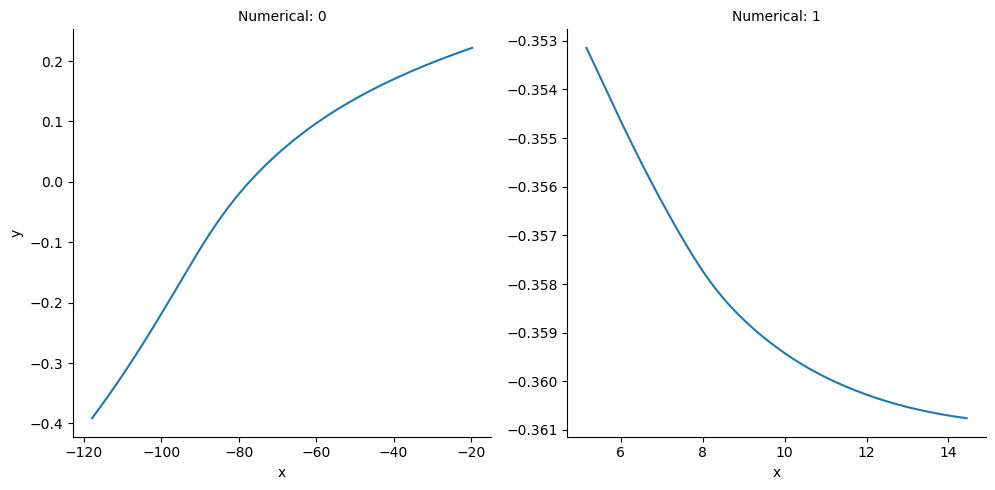

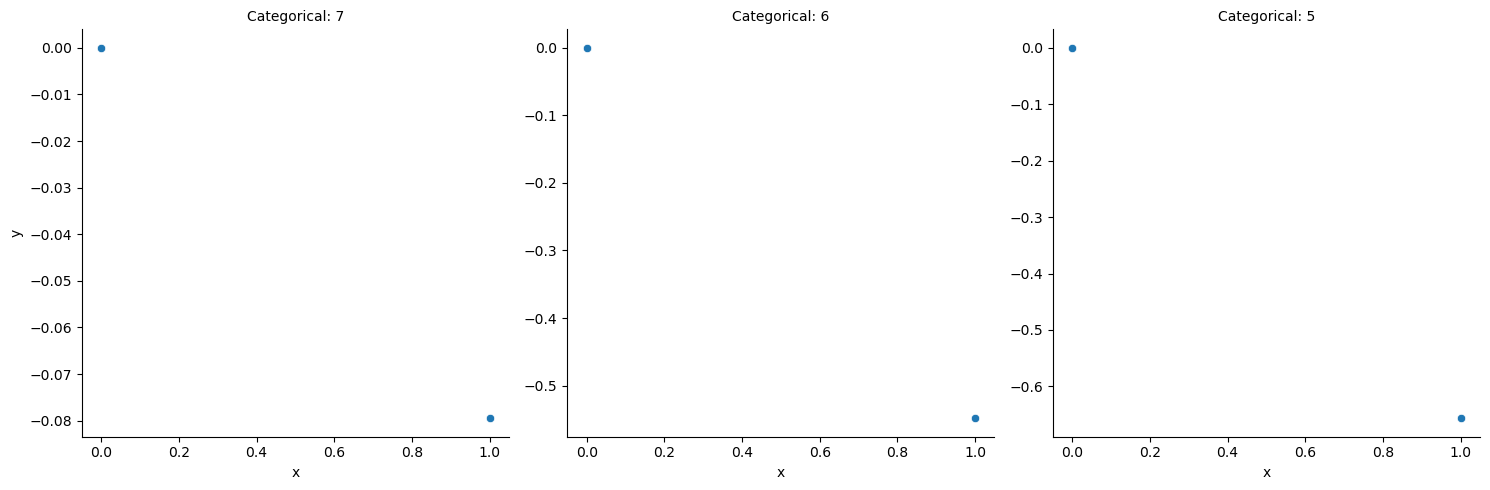

In [31]:
model._program.plot_shape_functions(
    dataset.numerical_ranges,
    dataset.categorical_values
)


In [11]:
from sklearn.base import BaseEstimator, RegressorMixin
from pycox.models.cox import _CoxPHBase
import torchtuples as tt


class SymRegPH(BaseEstimator, RegressorMixin, _CoxPHBase):
    """
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions
    """

    def __init__(self, model):
        self.model = model

    def fit(self, X, y, sample_weight, *args, **kwargs):
        self.model.fit(X, y, sample_weight=sample_weight)
        return self

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return self.model.predict(X)

    def silent(self):
        return self.model.set_params(verbose=False)

model_wrapped = SymRegPH(model)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

C-index: 0.3591015818535619
pycox PLL: 6.772125244140625
torchsurv NPLL: 7.3882880210876465
IBS: 0.16699629798911025


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/paperspace/SurvSHAREs/survshares/plot.py:42: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/lifelines/fitters/mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.10028583138762266
E50 =  0.06269016093804985


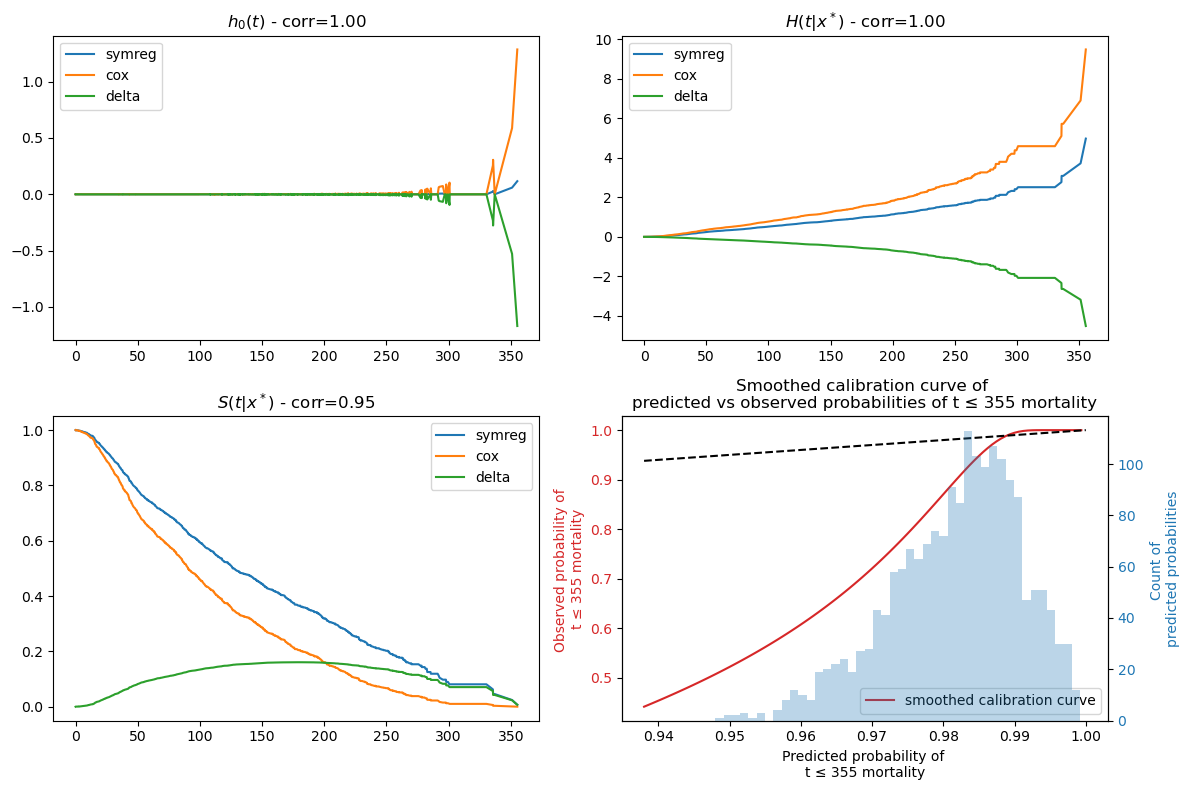

In [12]:
from lifelines import CoxPHFitter
from survshares.metrics import (
    c_index, 
    partial_likelihood,
    integrated_brier,
    negative_pll
)
import matplotlib.pyplot as plt 
from survshares.plot import survival_probability_calibration

class EvalSymRegPH:
    def __init__(self, model):
        self.model = model

    def score(self, X, T, E, sign=1):
        y_pred = sign * self.model.predict(X)
        h0_pred = self.model.compute_baseline_hazards(X, (T, E))
        surv_pred = self.model.predict_surv_df(X)
        print(f"C-index: {c_index(T, y_pred, E)}")
        print(f"pycox PLL: {partial_likelihood(T, y_pred, E)}")
        print(f"torchsurv NPLL: {negative_pll(T, y_pred, E)}")
        print(f"IBS: {integrated_brier(surv_pred, E, T)}")

    def plot_estimands(self, X, T, E, h0_scale_factor=1):
        X_df = pd.DataFrame(X).assign(time=T, event=E)
        cph = CoxPHFitter()
        cph.fit(X_df, duration_col="time", event_col="event")

        # This must run & store results in the symreg_cidx object before predict_cumulative_hazards can run
        h0_pred = self.model.compute_baseline_hazards(X, (T, E))
        h0_pred_scaled = h0_pred * h0_scale_factor
        h0_true = cph.baseline_hazard_["baseline hazard"]
        h0_corr = h0_pred.corr(h0_true, method="pearson")

        H0_pred = self.model.compute_baseline_cumulative_hazards(
            baseline_hazards_=h0_pred_scaled
        )
        H0_true = cph.baseline_cumulative_hazard_["baseline cumulative hazard"]
        H0_corr = H0_pred.corr(H0_true, method="pearson")

        # Select a random row in X
        idx = np.random.randint(0, len(X) - 1)
        X_star = X[idx : idx + 1]

        H_pred = self.model.predict_cumulative_hazards(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        H_true = cph.predict_cumulative_hazard(X_star)[0]
        H_corr = H_pred.corr(H_true, method="pearson")

        S_pred = self.model.predict_surv(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        S_true = cph.predict_survival_function(X_star)[0]
        S_corr = pd.Series(S_pred).corr(S_true, method="pearson")

        surv_pred = self.model.predict_surv_df(X)

        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        ax = np.ravel(ax)

        h0_dict = dict(symreg=h0_pred, cox=h0_true, delta=h0_pred_scaled - h0_true)
        if h0_scale_factor != 1:
            h0_dict["symreg_scaled"] = h0_pred_scaled

        pd.DataFrame(h0_dict).plot(ax=ax[0], title=f"$h_0(t)$ - corr={h0_corr:.2f}")
        pd.DataFrame(dict(symreg=H_pred, cox=H_true, delta=H_pred - H_true)).plot(
            ax=ax[1], title=f"$H(t|x^*)$ - corr={H_corr:.2f}"
        )
        pd.DataFrame(dict(symreg=S_pred, cox=S_true, delta=S_pred - S_true)).plot(
            ax=ax[2], title=f"$S(t|x^*)$ - corr={S_corr:.2f}"
        )

        survival_probability_calibration(surv_pred, T+0.01, E, t0=(T+0.01).max(), ax=ax[3])

EvalSymRegPH(model_wrapped).score(X, T, E)
EvalSymRegPH(model_wrapped).plot_estimands(X,T,E)